In [1]:
# 2D Toy training example
# Goal: examine how the gradients change the center and sigma of a single neuron
# Conclusions: Center Gradients are correct (moves to the right center)
# Further questions: What's going on with sigma?

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

# import sys
# sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research')
import torch_helper_lib as th

In [5]:
# random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [7]:
# Define 2d Toy Data

# number of dimensions of the data
num_dim = 2

# gaussian target parameters
data_centers = 1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 1000

samples_xs = np.array([np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
samples_labels = np.array([ [1] if x>np.matmul(data_centers, sep_plane) else [-1] for x in np.matmul(samples_xs, sep_plane)])

<IPython.core.display.Javascript object>


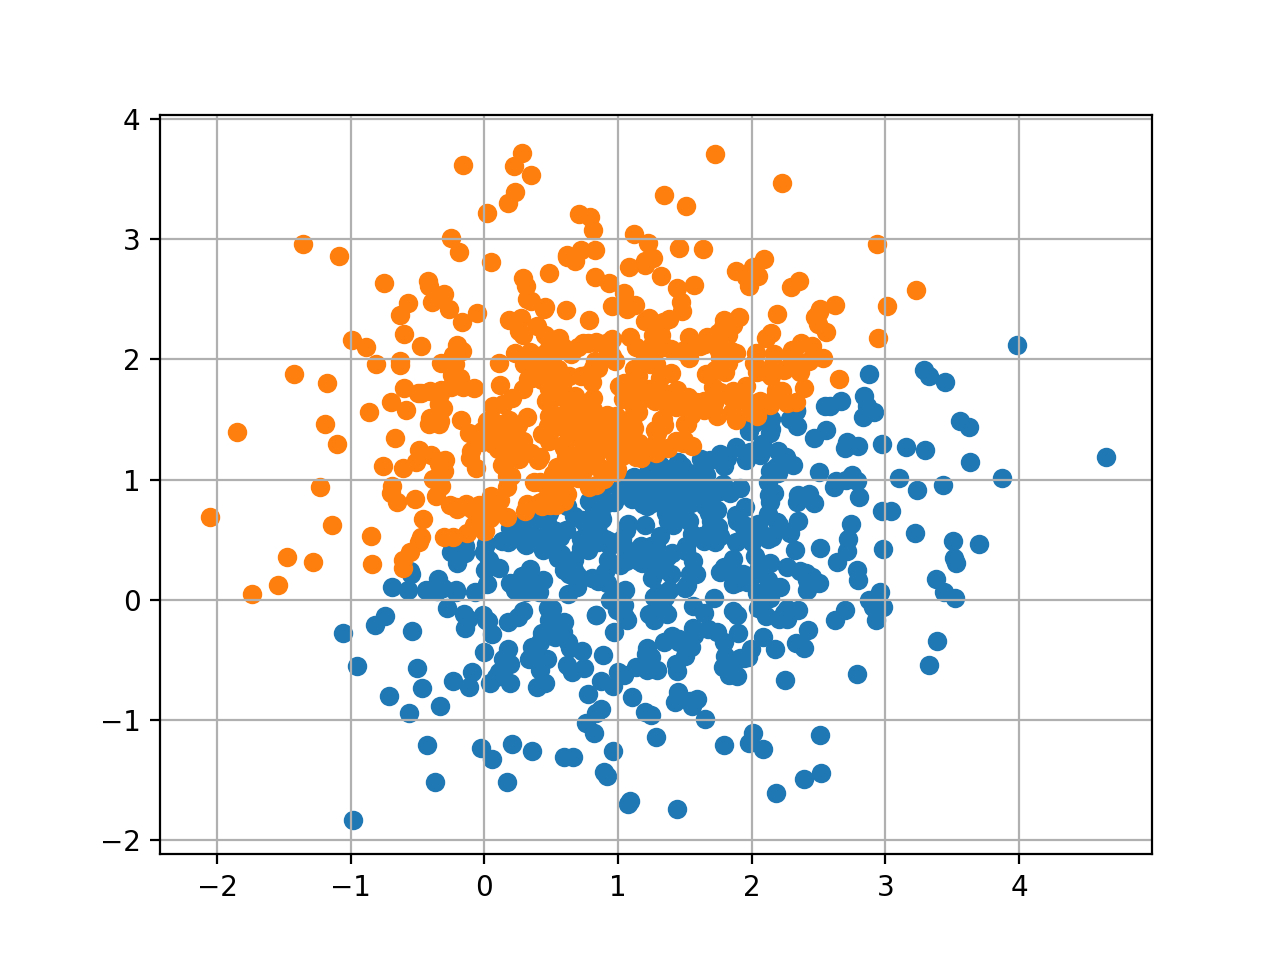

In [8]:
# 2D Check 
samples_x_1 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==1]
samples_y_1 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==1]

samples_x_2 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==-1]
samples_y_2 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==-1]


plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.grid(True)
plt.show()

In [9]:
# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)
# tensor_x = torch.stack([torch.Tensor(i) for i in zip(samples_x, samples_y)]) # transform to torch tensors
# tensor_y = torch.stack([torch.Tensor(i) for i in samples_labels])

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [10]:
# Define a Finite Gaussian Neural Network
class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = th.FGN_layer(2,1)

    def forward(self, x):
        x,l = self.l1(x)
        # clip res to +1
        x  = torch.clamp(x, min=-1.0, max=1.0)

        return x,l

In [11]:
# Initialize the network
model = FGNet().to(device)

In [12]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
print("Training?", model.training) 

# check sizes
print("l1")
print(model.l1.weights.size()) 
print(model.l1.centers.size()) 
print(model.l1.sigs.size())
print(model.l1.pis.size())

# check weights before training
print("l1")
print(model.state_dict())

FGNet(
  (l1): FGN_layer()
)
[torch.Size([1, 2]), torch.Size([1, 2]), torch.Size([1]), torch.Size([1])]
Training? True
l1
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1])
torch.Size([1])
l1
OrderedDict([('l1.weights', tensor([[ 1.1382, -0.0162]], device='cuda:0')), ('l1.centers', tensor([[ 0.0041, -0.0056]], device='cuda:0')), ('l1.sigs', tensor([1.9840], device='cuda:0')), ('l1.pis', tensor([1.], device='cuda:0'))])


In [13]:
class sigma_loss(torch.nn.modules.loss._Loss):
    
    def __init__(self):
        super(sigma_loss,self).__init__()
        
    def forward(self, model, lmbda):
# #         sig_loss =0
#         sig_list = torch.Tensor(0)
#         for k in model.state_dict().keys():
#             if 'sigs' in k:
#                 sig_list.append(model.state_dict()[k])
                
#         sig_loss = torch.sum(torch.abs(sig_list)**1)

        # HACK: only works on this model for now
        sig_loss = torch.sum(torch.abs(model.l1.sigs)**2)
    
        return lmbda*sig_loss

In [14]:
# importances of the constraints
lmbda = (4.0*0.1/len(my_dataloader.dataset))
print(lmbda)

# loss function
def loss_func(model, output, target):
    
    # split output into pred and likelihoods
    output, likelihood = output
    
    # normal MSE loss
    mse_loss = 1.0*F.mse_loss(output, target)
    # sum of sigma squares loss
    sig_loss = 1.0*lmbda*torch.sum(torch.abs(model.l1.sigs)**2)
    # negative log likelihood over gaussian loss
    nllg_loss = 10.0*lmbda*torch.sum(likelihood)
    
    return mse_loss + sig_loss + nllg_loss

0.0005


In [15]:
# number of correct pred function
def pred_func(output, target):
    output,_ = output
    pred = torch.Tensor.sign(output)
    correct = pred.eq(target.view_as(pred)).sum().item()   
    return correct

In [16]:
# model_optimizer
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5, nesterov=True)


In [17]:
epochs = 100
train_res = th.train(model, device, my_dataloader, loss_func, optimizer, epochs, save_hist=2, verbose=True, pred_func=pred_func, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 1.4023, Accuracy: 491/800 (61%)
Test set - Average loss: 0.7649, Accuracy: 131/200 (66%)
Epoch 1 Train set - Average loss: 1.2758, Accuracy: 557/800 (70%)
Test set - Average loss: 0.6855, Accuracy: 148/200 (74%)
Epoch 2 Train set - Average loss: 1.1908, Accuracy: 611/800 (76%)
Test set - Average loss: 0.6170, Accuracy: 158/200 (79%)
Epoch 3 Train set - Average loss: 1.1130, Accuracy: 657/800 (82%)
Test set - Average loss: 0.5500, Accuracy: 166/200 (83%)
Epoch 4 Train set - Average loss: 1.0392, Accuracy: 680/800 (85%)
Test set - Average loss: 0.4868, Accuracy: 173/200 (86%)
Epoch 5 Train set - Average loss: 0.9719, Accuracy: 703/800 (88%)
Test set - Average loss: 0.4313, Accuracy: 178/200 (89%)
Epoch 6 Train set - Average loss: 0.9133, Accuracy: 717/800 (90%)
Test set - Average loss: 0.3855, Accuracy: 182/200 (91%)
Epoch 7 Train set - Average loss: 0.8644, Accuracy: 733/800 (92%)
Test set - Average loss: 0.3495, Accuracy: 189/200 (94%)
Epoch 8 Train se

Test set - Average loss: 0.1666, Accuracy: 200/200 (100%)
Epoch 66 Train set - Average loss: 0.5691, Accuracy: 796/800 (100%)
Test set - Average loss: 0.1659, Accuracy: 200/200 (100%)
Epoch 67 Train set - Average loss: 0.5683, Accuracy: 796/800 (100%)
Test set - Average loss: 0.1651, Accuracy: 200/200 (100%)
Epoch 68 Train set - Average loss: 0.5674, Accuracy: 796/800 (100%)
Test set - Average loss: 0.1644, Accuracy: 200/200 (100%)
Epoch 69 Train set - Average loss: 0.5666, Accuracy: 797/800 (100%)
Test set - Average loss: 0.1638, Accuracy: 200/200 (100%)
Epoch 70 Train set - Average loss: 0.5658, Accuracy: 797/800 (100%)
Test set - Average loss: 0.1631, Accuracy: 200/200 (100%)
Epoch 71 Train set - Average loss: 0.5650, Accuracy: 797/800 (100%)
Test set - Average loss: 0.1624, Accuracy: 200/200 (100%)
Epoch 72 Train set - Average loss: 0.5642, Accuracy: 797/800 (100%)
Test set - Average loss: 0.1618, Accuracy: 200/200 (100%)
Epoch 73 Train set - Average loss: 0.5634, Accuracy: 797/800

In [18]:
th.test(model, device, my_test_dataloader, loss_func, verbose=True, pred_func=pred_func)

Test set - Average loss: 0.1482, Accuracy: 200/200 (100%)


{'test_accuracy': 100.0, 'test_loss': 0.14821398272644729}

In [19]:
# print model state_dict post training
model.state_dict()

OrderedDict([('l1.weights', tensor([[ 1.7831, -3.8665]], device='cuda:0')),
             ('l1.centers', tensor([[1.0674, 1.0218]], device='cuda:0')),
             ('l1.sigs', tensor([1.4671], device='cuda:0')),
             ('l1.pis', tensor([1.], device='cuda:0'))])

<IPython.core.display.Javascript object>


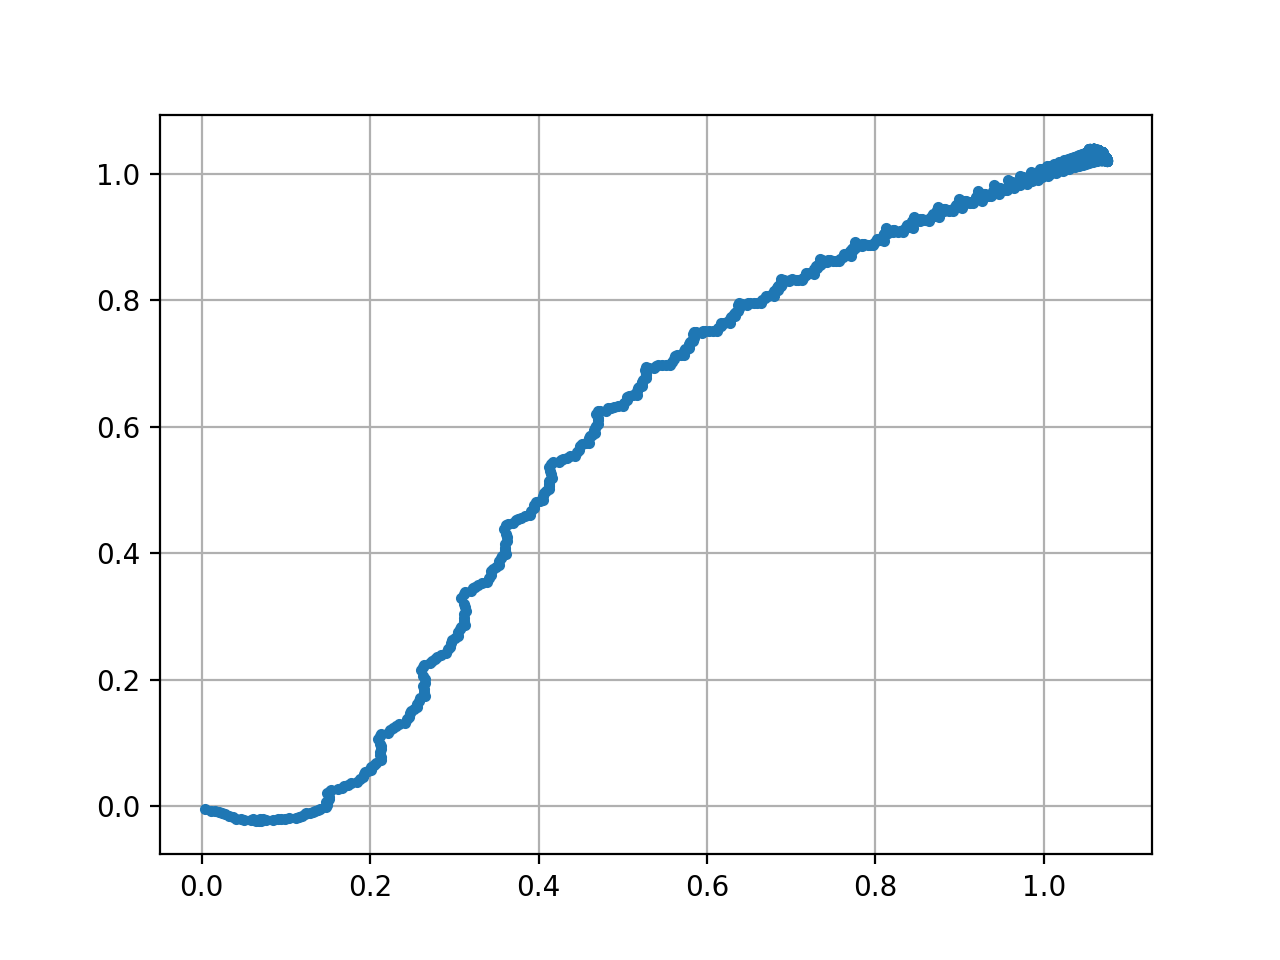

In [20]:
# compare center with target (1,1)
x, y = zip(*train_res['histories']['l1.centers'][:,0,:])
plt.plot(x,y, marker='.', linestyle='-')
# plt.axis([-3,3, -3, 3])
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


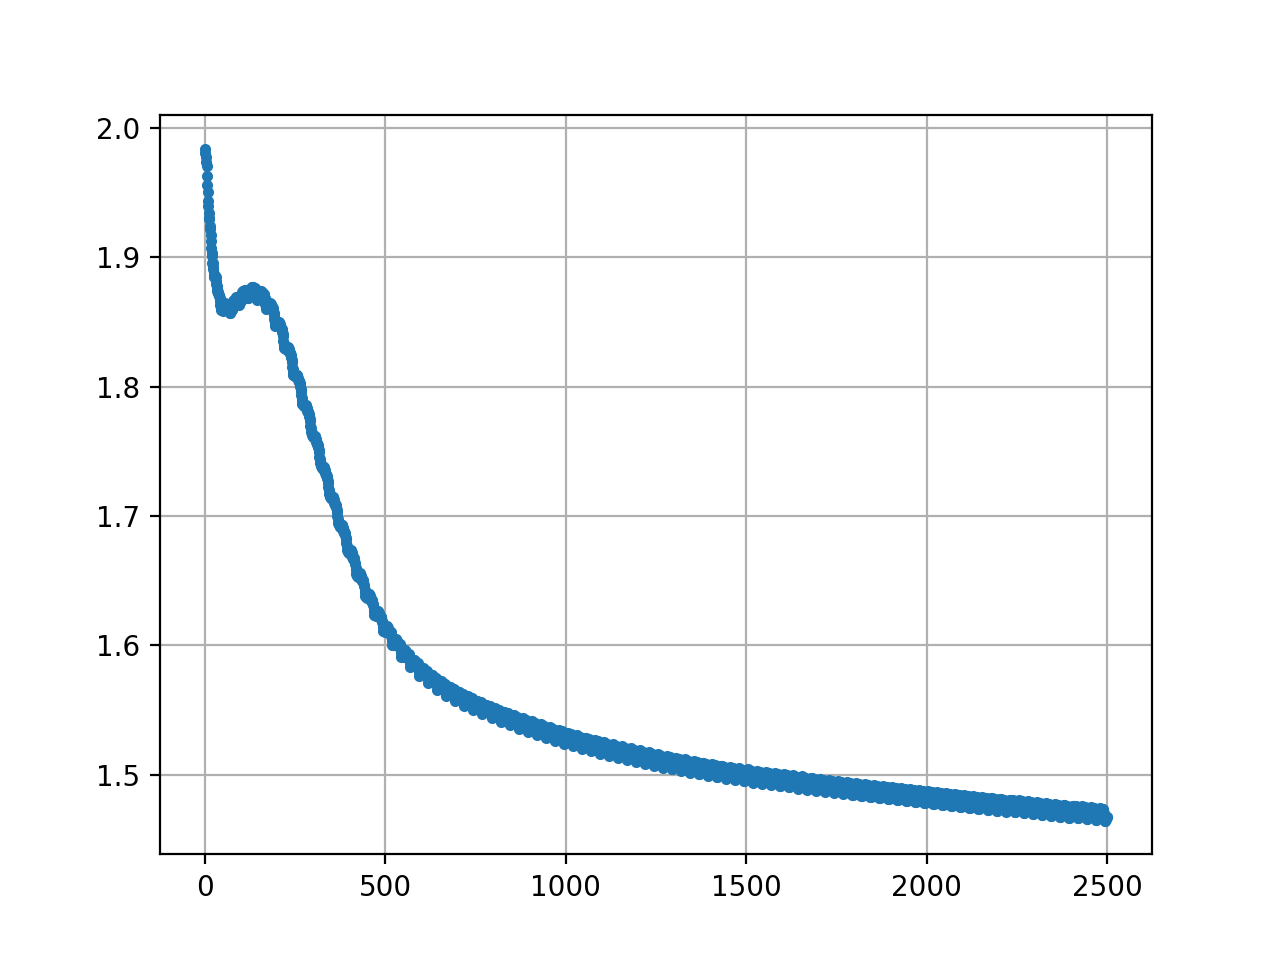

In [21]:
# plot sigma history
plt.plot(train_res['histories']['l1.sigs'][:,0], marker='.', linestyle=' ')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


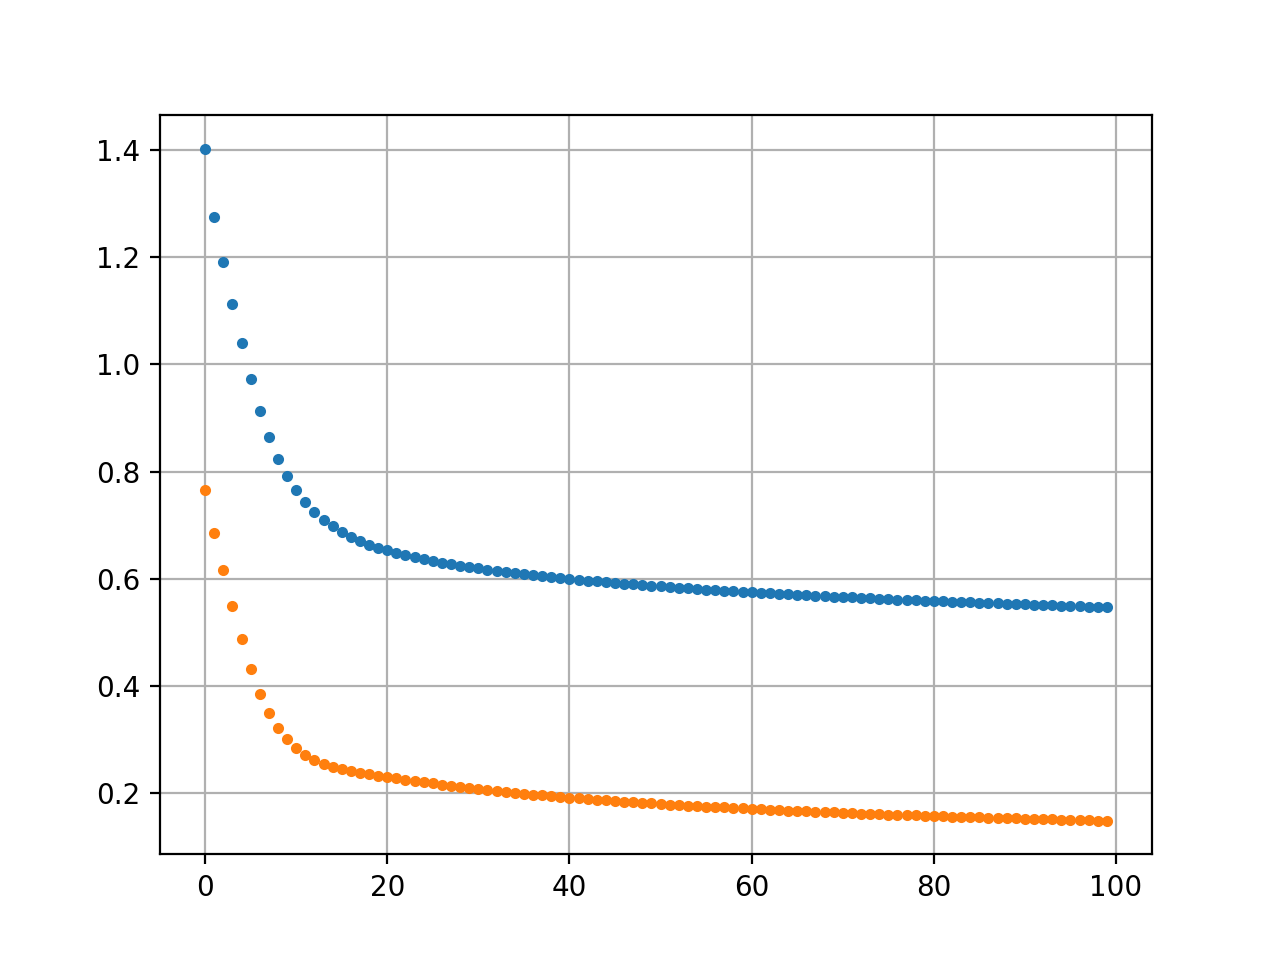

<IPython.core.display.Javascript object>


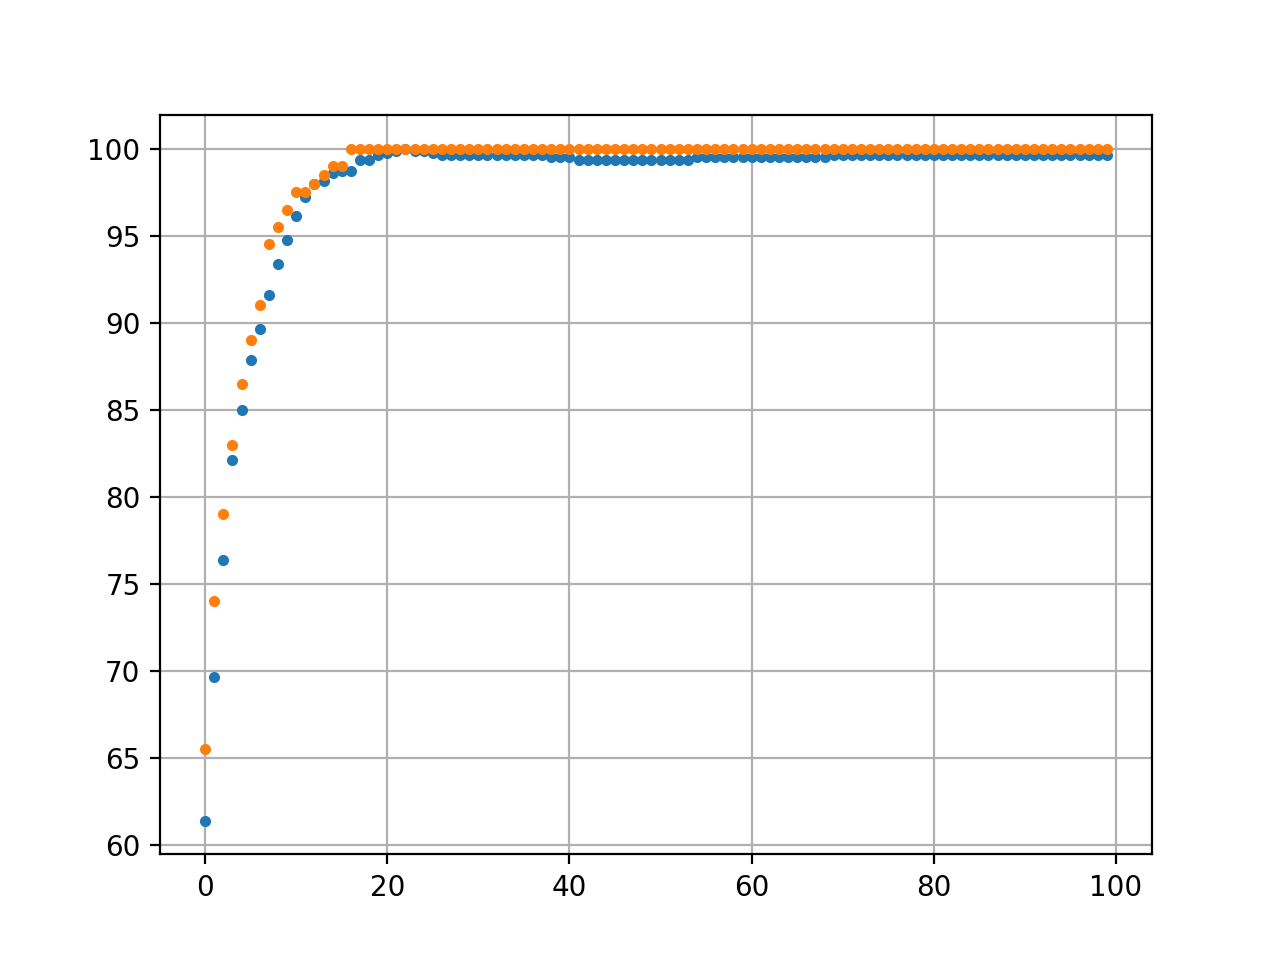

In [22]:
# acc and loss hist
plt.plot(train_res['train_loss_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_loss_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

plt.plot(train_res['train_acc_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_acc_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()